In [1]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')
# os.chdir(config['PATH']['ROOT_DIR'])

# # Load data
df = pd.read_csv(config['PATH']['DATA_DIR'] + '/dataset_mood_smartphone.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# time to datetime
df['time'] = pd.to_datetime(df['time'])

# get all duplicate observations for the same time and person
df_dupes = df[df.duplicated(subset=['time', 'id', 'variable'], keep=False)].copy()

# drop duplicates
df.drop_duplicates(subset=['time', 'id', 'variable'], keep='first', inplace=True)

In [2]:
# TODO: 
# DONE: Forward fill valence and arousal
# DONE: Remove appCat.builtin negative values
# DONE: Remove appCat outliers
# Impute valence, arousal and mood
# Impute long term missing values with mean instead of ffill (for valence and arousal)
# Aggregate to daily mood
# Decide on aggregation method for each variable

In [3]:
all_id = df['id'].unique()
# subset of df with only 5 id's
df_sub = df[df['id'].isin(all_id[:5])].copy()

## Extreme values appCat variables
There are many outliers in the appCat variables, this is not ideal for numerical stability. We will one hot encode these outliers per variable and remove the outlier from the original observation

In [4]:
#  We will one hot encode these outliers per variable and remove the outlier from the original observation
#  Moreover we will remove all negative values

all_vars = df['variable'].unique()
appVars = [var for var in all_vars if 'appCat' in var]
appVars

for var in appVars:
    df_var_cur = df[df['variable'] == var]
    # Iterate over observations

    # Get 95th percentile
    perc98 = np.percentile(df_var_cur['value'], 98)

    # Get all idx where value is smaller than 0
    idx = df_var_cur[df_var_cur['value'] < 0].index
    df.drop(idx, axis=0, inplace=True)

    # Get all idx where value is larger than 95th percentile
    idx_98 = df_var_cur[df_var_cur['value'] > 1800].index

    # Change variable name to var_outlier
    # df.loc[idx_98, 'variable'] = var + '_outlier'
    df.loc[idx_98, 'value'] = 1800


## Impute valence, arousal and mood using ARMA and Kalman smoother.
* Fit ARMA and obtain state space model for each series
* Add in the NA for missing values
* Impute using kalman smoother.

In [5]:
series = ['mood', 'circumplex.arousal', 'circumplex.valence']

df_imputed, compare_df_mood = impute_ARMA(df, 'mood', verbose = 0)
df_imputed, compare_df_valence = impute_linear(df_imputed, 'circumplex.valence', verbose = 0)
df_imputed, compare_df_arousal = impute_linear(df_imputed, 'circumplex.arousal', verbose = 0)

Obtaining ARMA parameters for variable:  mood


100%|██████████| 27/27 [00:56<00:00,  2.10s/it]


Creating missing values for variable:  mood


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


Imputing missing values for variable:  mood


100%|██████████| 27/27 [00:02<00:00, 12.17it/s]


Creating missing values for variable:  circumplex.valence


100%|██████████| 27/27 [00:01<00:00, 18.05it/s]


Creating missing values for variable:  circumplex.arousal


100%|██████████| 27/27 [00:01<00:00, 16.79it/s]


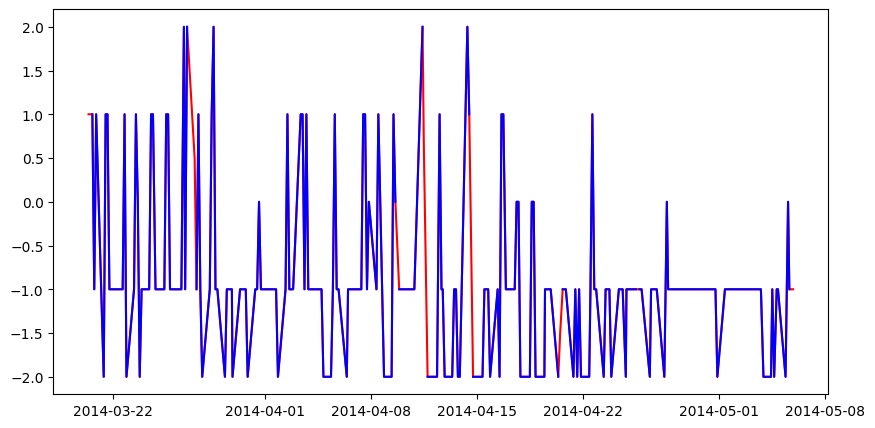

In [6]:
cmp_df = compare_df_arousal['AS14.30']
idx_nan = np.isnan(cmp_df['value'])
nan_df = cmp_df.loc[idx_nan]
# Plot value (dots) and Nan's (red dots) and smoothed value
plt.figure(figsize=(10,5))
plt.plot(cmp_df['time'], cmp_df['imputed'], color = 'red')
plt.plot(cmp_df['time'], cmp_df['value'], color = 'blue')

In [9]:
# Get all variables
variables = df_imputed['variable'].unique()

# Iterate over variables
for variable in variables:
    # Get the data for this variable
    df_variable = df_imputed[df_imputed['variable'] == variable]

    # Get 95th percentile
    percentile_95 = np.percentile(df_variable['value'], 95)

    # Describe value column for variable
    print(f"Variable {variable}:")
    print(df_variable['value'].describe())

Variable mood:
count    6777.000000
mean        6.996402
std         0.987742
min         0.000000
25%         6.711996
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
Variable circumplex.arousal:
count    6777.000000
mean       -0.092371
std         1.018814
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
Variable circumplex.valence:
count    6777.000000
mean        0.687989
std         0.644222
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
Variable activity:
count    22965.000000
mean         0.115958
std          0.186946
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dtype: float64
Variable screen:
count    96578.000000
mean        75.335206
std        253.822497
min          0.035000
25%        

In [10]:
# Save df with joblib
dump(df_imputed, config['PATH']['DATA_DIR'] + '/df_cleaned.joblib')

['./data/df_cleaned.joblib']